In [31]:
%load_ext autoreload
%autoreload 2

In [4]:
# !pip install --upgrade torchvision
# !pip install --upgrade torch

In [80]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import IPython.display as ipd
from moviepy.editor import AudioFileClip

import vggish_input
import conv

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.2.2


### Params

In [104]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = "/Users/aziai/Downloads/hymenoptera_data/"
data_dir = "/Users/aziai/Downloads/casino/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

segments = {
    "movies_casino_royale_2006.mp4": {
        'kissing': [
            (2 * 3600 + 4 * 60 + 6, 2 * 3600 + 4 * 60 + 9),
            (0 * 3600 + 37 * 60 + 33, 0 * 3600 + 38 * 60 + 34),
            (2 * 3600 + 0 * 60 + 26, 2 * 3600 + 0 * 60 + 37),
        ],
        'not': [
            (0 * 3600 + 60 * 9 + 47, 0 * 3600 + 60 * 9 + 57),
            (1 * 3600 + 9 * 60 + 39, 1 * 3600 + 9 * 60 + 45),
            (1 * 3600 + 51 * 60 + 56, 1 * 3600 + 52 * 60 + 2),
        ]
    },
    'movies_goldeneye_1995.mp4': {
        'kissing': [
            (0 * 3600 + 16 * 60 + 51, 0 * 3600 + 17 * 60 + 0),
            (1 * 3600 + 38 * 60 + 51, 1 * 3600 + 39 * 60 + 2),
            (2 * 3600 + 4 * 60 + 53, 2 * 3600 + 5 * 60 + 15),
        ],
        'not': [
            (0 * 3600 + 28 * 60 + 26, 0 * 3600 + 28 * 60 + 40),
            (0 * 3600 + 52 * 60 + 16, 0 * 3600 + 52 * 60 + 38),
            (1 * 3600 + 21 * 60 + 50, 1 * 3600 + 21 * 60 + 59),
        ]
    }
}

### Explore

In [33]:
audioclip = AudioFileClip("/Users/aziai/Downloads/movies_goldeneye_1995.mp4")

In [66]:
audioclip

In [57]:
q = VideoFileClip('/Users/aziai/Downloads/movies_goldeneye_1995_kissing_3.mp4')
q

In [73]:
q.audio.write_audiofile('u.wav')

chunk:   0%|          | 2/486 [00:00<00:28, 17.21it/s, now=None]

MoviePy - Writing audio in %s


MoviePy - Done.


In [74]:
ipd.Audio('u.wav')

In [62]:
ex = vggish_input.wavfile_to_examples('u.wav')

In [63]:
ex.shape

(22, 96, 64)

In [64]:
q.duration

22.0

In [78]:
# can't read mp4
# sf.read('/Users/aziai/Downloads/movies_casino_royale_2006_not_1.mp4')

In [108]:
# Initialize the model for this run
model_ft, input_size, _ = conv.convnet_init(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/aziai/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:18<00:00, 13346961.75it/s]


### Processing

In [8]:
# TODO: move this into the package
!rm -rf ~/Downloads/casino
!mkdir -p /Users/aziai/Downloads/casino/train/kissing /Users/aziai/Downloads/casino/train/not
!mkdir -p /Users/aziai/Downloads/casino/val/kissing /Users/aziai/Downloads/casino/val/not

slice_clips(segments, root='/Users/aziai/Downloads/', fps=1)

target: /Users/aziai/Downloads/movies_casino_royale_2006_kissing_1.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_casino_royale_2006_kissing_3.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_casino_royale_2006_not_1.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_casino_royale_2006_not_2.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_casino_royale_2006_not_3.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/Downloads/movies_goldeneye_1995_kissing_1.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
5
target: /Users/aziai/D

In [109]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [110]:
device

device(type='cpu')

In [111]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
hi
	 classifier.6.weight
hi
	 classifier.6.bias


In [112]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x14ff28048>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x14ff28668>}

In [113]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


KeyboardInterrupt: 

Epoch 0/14
----------
train Loss: 0.3134 Acc: 0.9094
val Loss: 1.3234 Acc: 0.4613

Epoch 1/14
----------
train Loss: 0.2211 Acc: 0.9145
val Loss: 1.9410 Acc: 0.4774

Epoch 2/14
----------
train Loss: 0.2032 Acc: 0.9145
val Loss: 1.3396 Acc: 0.5489

Epoch 3/14
----------
train Loss: 0.1794 Acc: 0.9145
val Loss: 2.1199 Acc: 0.5168

Epoch 4/14
----------
train Loss: 0.1408 Acc: 0.9145
val Loss: 1.8238 Acc: 0.5139

Epoch 5/14
----------
train Loss: 0.1545 Acc: 0.9145
val Loss: 1.4714 Acc: 0.5314

Epoch 6/14
----------
train Loss: 0.1360 Acc: 0.9152
val Loss: 1.5584 Acc: 0.6438

Epoch 7/14
----------
train Loss: 0.1201 Acc: 0.9171
val Loss: 2.1923 Acc: 0.5533

Epoch 8/14
----------
train Loss: 0.1379 Acc: 0.9190
val Loss: 1.4044 Acc: 0.6949

Epoch 9/14
----------
train Loss: 0.1216 Acc: 0.9184
val Loss: 2.7929 Acc: 0.6628

Epoch 10/14
----------
train Loss: 0.1295 Acc: 0.9203
val Loss: 1.5944 Acc: 0.7007

Epoch 11/14
----------
train Loss: 0.1167 Acc: 0.9235
val Loss: 2.3126 Acc: 0.6569

Ep

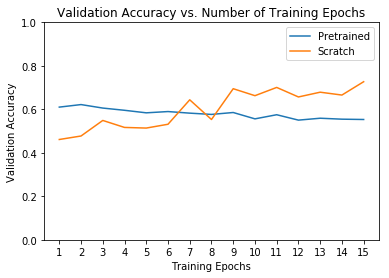

In [213]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))



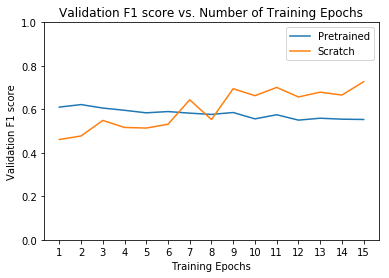

In [215]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation F1 score vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation F1 score")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Concat

### VGGish

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['KMP_DUPLICATE_LIB_OK']

'TRUE'

In [2]:
import torch

In [3]:
from kissing_detector import KissingDetector

In [4]:
model_name = 'resnet'
num_classes = 2
feature_extract = True

In [5]:
kd = KissingDetector(model_name, num_classes, feature_extract)

In [6]:
kd

KissingDetector(
  (conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [114]:
from data import AudioVideo

In [115]:
av = AudioVideo('x')

In [118]:
a, v, c = av[0]

In [7]:
kd(torch.rand((1, 1, 96, 64)),
   torch.rand((1, 3, kd.conv_input_size, kd.conv_input_size)))

tensor([[-0.7212,  0.5589]], grad_fn=<AddmmBackward>)

In [120]:
datasets = {x: AudioVideo(x) for x in ['train', 'val']}

In [121]:
dataloaders_dict = {x: torch.utils.data.DataLoader(datasets[x],
                                                   batch_size=batch_size,
                                                   shuffle=True, num_workers=4)
                    for x in ['train', 'val']}

In [122]:
model_ft, hist = train_model(kd,
                             dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             is_inception=(model_name == "inception"))


Epoch 0/14
----------


ValueError: too many values to unpack (expected 2)

In [119]:
kd(a, v)

tensor([[-0.7130,  0.5764]], grad_fn=<AddmmBackward>)

In [8]:
# !curl https://raw.githubusercontent.com/IBM/MAX-Audio-Classifier/master/assets/piano.wav --output piano.wav

In [9]:
import vggish_input

In [10]:
examples = vggish_input.wavfile_to_examples("piano.wav")

In [11]:
examples.shape

(10, 96, 64)

In [12]:
import soundfile as sf
import numpy as np

In [13]:
wav_data, sr = sf.read('piano.wav', dtype='int16')

In [14]:
samples = wav_data / 32768.0

In [15]:
samples.shape

(449519, 2)

In [16]:
data = np.mean(wav_data, axis=1)

In [17]:
data

array([ 5. , 16.5, 29.5, ...,  0. ,  0. ,  0. ])

In [18]:
import vggish_params

In [19]:
vggish_params.SAMPLE_RATE

16000

In [20]:
sr

44100

In [21]:
data.shape

(449519,)

In [22]:
import resampy

In [23]:
data = resampy.resample(data, sr, vggish_params.SAMPLE_RATE)

In [24]:
data.shape

(163090,)

In [25]:
import torch

In [26]:
torch.from_numpy(data)

tensor([  5.4787,  41.1916, 101.0292,  ...,   0.0000,   0.0000,   0.0000],
       dtype=torch.float64)

In [29]:
examples = vggish_input.wavfile_to_examples("piano.wav")
examples = examples[:,None,:,:] # add dummy dimension for "channel"
examples = torch.from_numpy(examples).float() # Convert input example to float rather

In [31]:
kd.vggish(examples).shape

torch.Size([10, 128])

In [111]:
a, b, c = convnet_init('resnet', 2, True)

In [114]:
b

224

In [110]:
a(torch.rand((5, 3, b, b))).shape[1]

[autoreload of conv failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/aziai/Dropbox/github/cs231n-project/conv.py", line 28
    output_size =

512

In [64]:
a = dataloaders_dict['train']

In [77]:
a.batch_sampler

In [60]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(a,
                             dataloaders_dict,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs,
                             is_inception=(model_name=="inception"))

Epoch 0/14
----------


Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

In [48]:
a(torch.rand((96, 3, 7, 7)))

RuntimeError: shape '[96, 1000]' is invalid for input of size 49152